# 🍅 Tomato Leaf Disease Detection & Segmentation
This notebook trains a YOLO model for detecting tomato leaf diseases, then uses SAM2 to segment the diseased areas. All important assets are saved to Google Drive for persistence.

## 1. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Install Required Libraries

In [4]:
!pip install --upgrade ultralytics
!pip install roboflow

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="LUkeC2s1h95yFzJH9Fny")
project = rf.workspace("test-8").project("tomato-leaf-disease-pubio")
version = project.version(7)
dataset = version.download("yolo26")

loading Roboflow workspace...
loading Roboflow project...


## 3. Download Dataset (with cache check)

In [6]:
import os
from roboflow import Roboflow

# Define paths
drive_model_dir = "/content/drive/MyDrive/tomato_leaf_model"
os.makedirs(drive_model_dir, exist_ok=True)

dataset_dir = "/content/Tomato-Leaf-Disease-7"
if not os.path.exists(dataset_dir):
    print("Downloading dataset...")
    rf = Roboflow(api_key="LUkeC2s1h95yFzJH9Fny")
    project = rf.workspace("test-8").project("tomato-leaf-disease-pubio")
    version = project.version(7)
    dataset = version.download("yolo26")
else:
    print("Dataset already exists, skipping download.")

Dataset already exists, skipping download.


## 4. Prepare Data Configuration

In [7]:
import yaml

data_yaml_path = os.path.join(dataset_dir, "data.yaml")

# Read and update paths
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

data_config['path'] = dataset_dir
data_config['train'] = 'train/images'
data_config['val'] = 'valid/images'
data_config['test'] = 'test/images'

with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print("data.yaml updated.")

data.yaml updated.


## 5. Train YOLO Model (or load from Drive)

In [8]:
from ultralytics import YOLO
import shutil

# Paths
drive_model_dir = "/content/drive/MyDrive/tomato_leaf_model"
os.makedirs(drive_model_dir, exist_ok=True)
model_save_path = os.path.join(drive_model_dir, "best.pt")

# Possible locations of previously trained model
old_model_path = "/content/runs/detect/train2/weights/best.pt"
alternate_old_path = "/content/runs/detect/train/weights/best.pt"  # in case you used a different folder

# Check if model already exists in Drive
if os.path.exists(model_save_path):
    print("Loading existing model from Google Drive...")
    model = YOLO(model_save_path)
# If not in Drive, check if we have a model from a previous run in local Colab
elif os.path.exists(old_model_path):
    print("Found previously trained model in local Colab. Copying to Drive and loading...")
    shutil.copy(old_model_path, model_save_path)
    model = YOLO(model_save_path)
elif os.path.exists(alternate_old_path):
    print("Found previously trained model in local Colab (alternate path). Copying to Drive and loading...")
    shutil.copy(alternate_old_path, model_save_path)
    model = YOLO(model_save_path)
else:
    print("No existing model found. Starting training...")
    model = YOLO("yolo26n.pt")
    results = model.train(
        data=data_yaml_path,
        epochs=25,
        imgsz=640,
        device=0,
        project=drive_model_dir,
        name='train',
        exist_ok=True
    )
    # The best model is saved in drive_model_dir/train/weights/best.pt; copy it to main folder
    trained_model = os.path.join(drive_model_dir, "train", "weights", "best.pt")
    if os.path.exists(trained_model):
        shutil.copy(trained_model, model_save_path)
    model = YOLO(model_save_path)

Found previously trained model in local Colab. Copying to Drive and loading...


## 6. Display Training Graphs

In [9]:
import matplotlib.pyplot as plt
from glob import glob

# Look for training plots (usually in drive_model_dir/train/)
plot_files = glob(f"{drive_model_dir}/train/*.png")
if plot_files:
    for plot in plot_files:
        img = plt.imread(plot)
        plt.figure(figsize=(10,8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(plot))
        plt.show()
else:
    print("No training plots found. (Training may have just finished, run this cell again after a moment.)")

No training plots found. (Training may have just finished, run this cell again after a moment.)


Found results.csv at: /content/runs/detect/train2/results.csv
Copied to Drive: /content/drive/MyDrive/tomato_leaf_model/train/results.csv


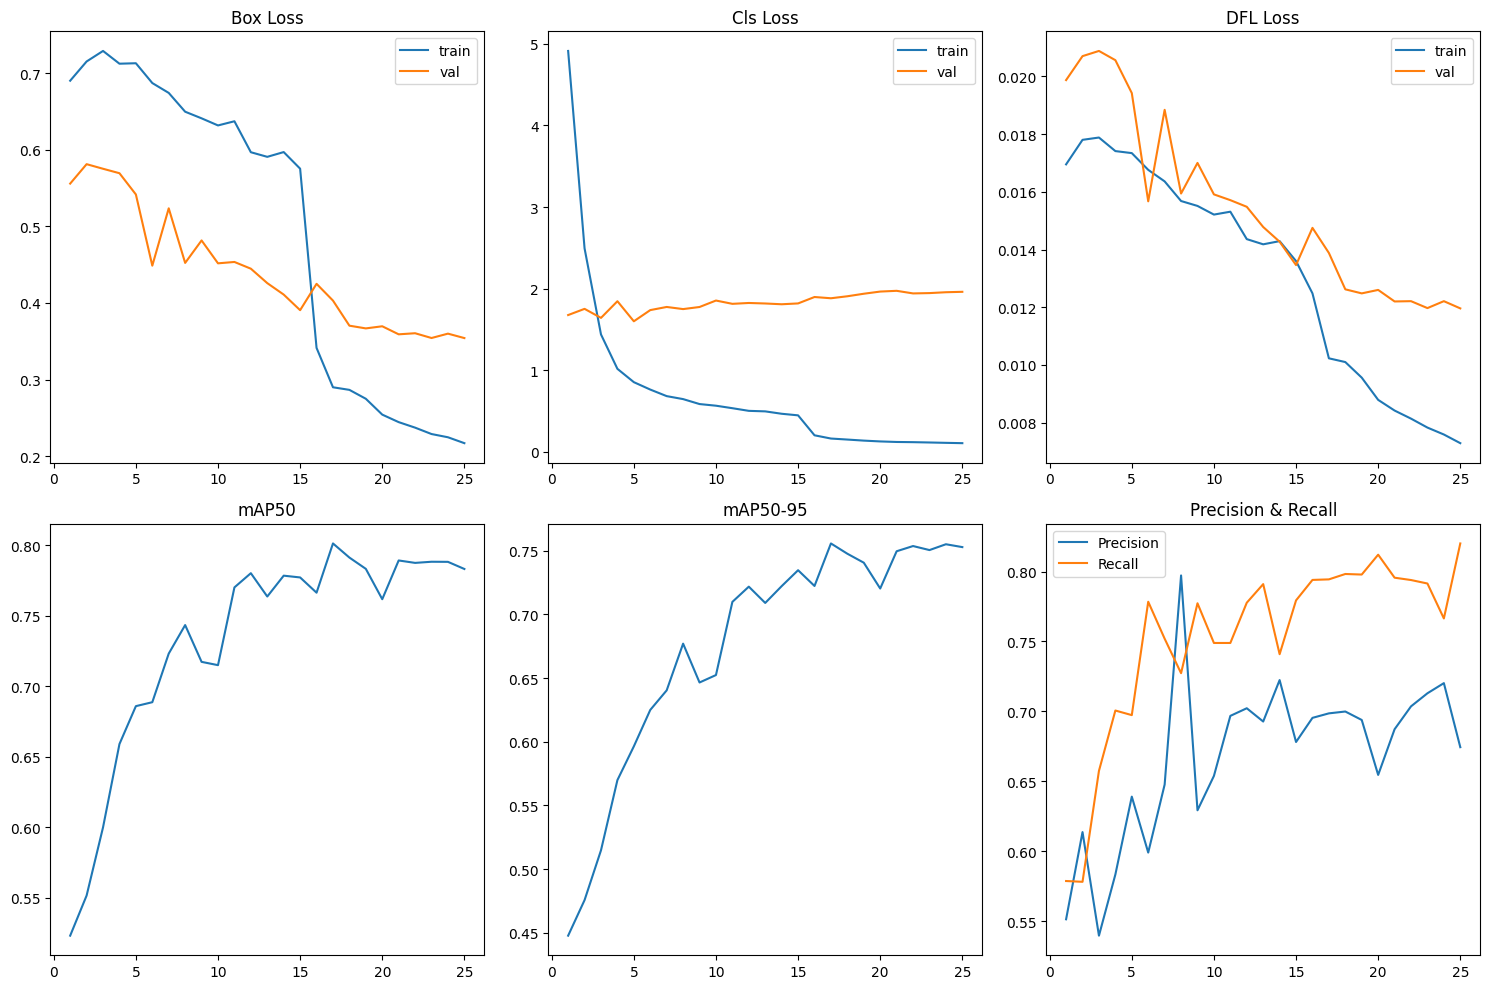

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Possible locations for results.csv
possible_paths = [
    os.path.join(drive_model_dir, 'train', 'results.csv'),           # new training folder
    '/content/runs/detect/train2/results.csv',                        # your previous run
    '/content/runs/detect/train/results.csv',                         # other common runs
    '/content/runs/detect/train3/results.csv',
]

# Also search any run folders in /content/runs/detect/
run_folders = glob.glob('/content/runs/detect/*/')
for folder in run_folders:
    csv_path = os.path.join(folder, 'results.csv')
    if os.path.exists(csv_path) and csv_path not in possible_paths:
        possible_paths.append(csv_path)

found = None
for path in possible_paths:
    if os.path.exists(path):
        found = path
        break

if found:
    print(f"Found results.csv at: {found}")
    # If it's not already in Drive, copy it there for future use
    if not found.startswith(drive_model_dir):
        dest = os.path.join(drive_model_dir, 'train', 'results.csv')
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        import shutil
        shutil.copy(found, dest)
        print(f"Copied to Drive: {dest}")
    df = pd.read_csv(found)
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot box loss
    if 'train/box_loss' in df.columns:
        axes[0].plot(df['epoch'], df['train/box_loss'], label='train')
        axes[0].plot(df['epoch'], df['val/box_loss'], label='val')
        axes[0].set_title('Box Loss')
        axes[0].legend()

    # Plot cls loss
    if 'train/cls_loss' in df.columns:
        axes[1].plot(df['epoch'], df['train/cls_loss'], label='train')
        axes[1].plot(df['epoch'], df['val/cls_loss'], label='val')
        axes[1].set_title('Cls Loss')
        axes[1].legend()

    # Plot dfl loss
    if 'train/dfl_loss' in df.columns:
        axes[2].plot(df['epoch'], df['train/dfl_loss'], label='train')
        axes[2].plot(df['epoch'], df['val/dfl_loss'], label='val')
        axes[2].set_title('DFL Loss')
        axes[2].legend()

    # Plot mAP50
    if 'metrics/mAP50(B)' in df.columns:
        axes[3].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
        axes[3].set_title('mAP50')

    # Plot mAP50-95
    if 'metrics/mAP50-95(B)' in df.columns:
        axes[4].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
        axes[4].set_title('mAP50-95')

    # Plot precision and recall
    if 'metrics/precision(B)' in df.columns and 'metrics/recall(B)' in df.columns:
        axes[5].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
        axes[5].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
        axes[5].set_title('Precision & Recall')
        axes[5].legend()

    plt.tight_layout()
    plt.show()
else:
    print("results.csv not found in any common location.")
    print("If you have trained before, the file might be in a different folder.")
    print("You can manually set the path below by editing the 'found' variable.")
    # Optionally allow manual input
    # manual = input("Enter full path to results.csv (or press Enter to skip): ").strip()
    # if manual and os.path.exists(manual):
    #     found = manual
    #     ... (repeat plotting)

## 7. Load SAM2 Model (cached in Drive)

In [10]:
from ultralytics import SAM

sam_weights_path = os.path.join(drive_model_dir, "sam2_b.pt")
if not os.path.exists(sam_weights_path):
    print("Downloading SAM2 weights...")
    sam_model = SAM("sam2_b.pt")
    !cp sam2_b.pt "{sam_weights_path}"
else:
    print("Loading SAM2 from Drive...")
    sam_model = SAM(sam_weights_path)

## 8. Helper Functions for Visualization

In [33]:
import cv2
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

# Get class names from data.yaml
with open(data_yaml_path, 'r') as f:
    class_names = yaml.safe_load(f)['names']

def plot_yolo_grid(images, results_list, class_names, max_cols=3):
    """Display a grid of images with YOLO bounding boxes."""
    num = len(images)
    cols = min(max_cols, num)
    rows = (num + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, (img, result) in enumerate(zip(images, results_list)):
        ax = axes[i] if num > 1 else axes
        im = img.copy()
        if result.boxes is not None:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = box.conf[0].item()
                cls_id = int(box.cls[0].item())
                label = f"{class_names[cls_id]}: {conf:.2f}"
                cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(im, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f"YOLO {i+1}")

    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

def plot_sam_grid(images, results_list, class_names, max_cols=3):
    """Display a grid with SAM masks: semi-transparent fill + colored outline."""
    num = len(images)
    cols = min(max_cols, num)
    rows = (num + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    # Generate distinct colors using a colormap
    num_classes = len(class_names)
    cmap = plt.cm.get_cmap('tab20', num_classes)
    colors = [tuple(int(c*255) for c in cmap(i)[:3]) for i in range(num_classes)]

    for i, (img, result) in enumerate(zip(images, results_list)):
        ax = axes[i] if num > 1 else axes
        im = img.copy()
        overlay = np.zeros_like(im, dtype=np.uint8)

        if result.masks is not None and len(result.masks) > 0:
            for j, mask in enumerate(result.masks.data):
                cls_id = int(result.boxes.cls[j].item()) if result.boxes is not None else 0
                color = colors[cls_id % num_classes]
                # Convert mask to numpy and ensure binary (0 or 255)
                mask_np = mask.cpu().numpy().astype(np.uint8) * 255
                # Resize to image size
                mask_resized = cv2.resize(mask_np, (im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)
                # Add to overlay (will be blended later)
                overlay[mask_resized > 0] = color
                # Also draw the outline in the same color
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(im, contours, -1, color, 2)  # outline

            # Blend overlay with original (light fill)
            im = cv2.addWeighted(im, 0.7, overlay, 0.3, 0)

            # Add class labels with background
            if result.boxes is not None:
                for box, cls in zip(result.boxes.xyxy, result.boxes.cls):
                    x1, y1, x2, y2 = map(int, box)
                    cls_id = int(cls.item())
                    label = class_names[cls_id]
                    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                    cv2.rectangle(im, (x1, y1-20), (x1+w, y1), (0,0,0), -1)
                    cv2.putText(im, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f"SAM {i+1}")

    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

## 9. Test YOLO on Multiple Images (Grid View)

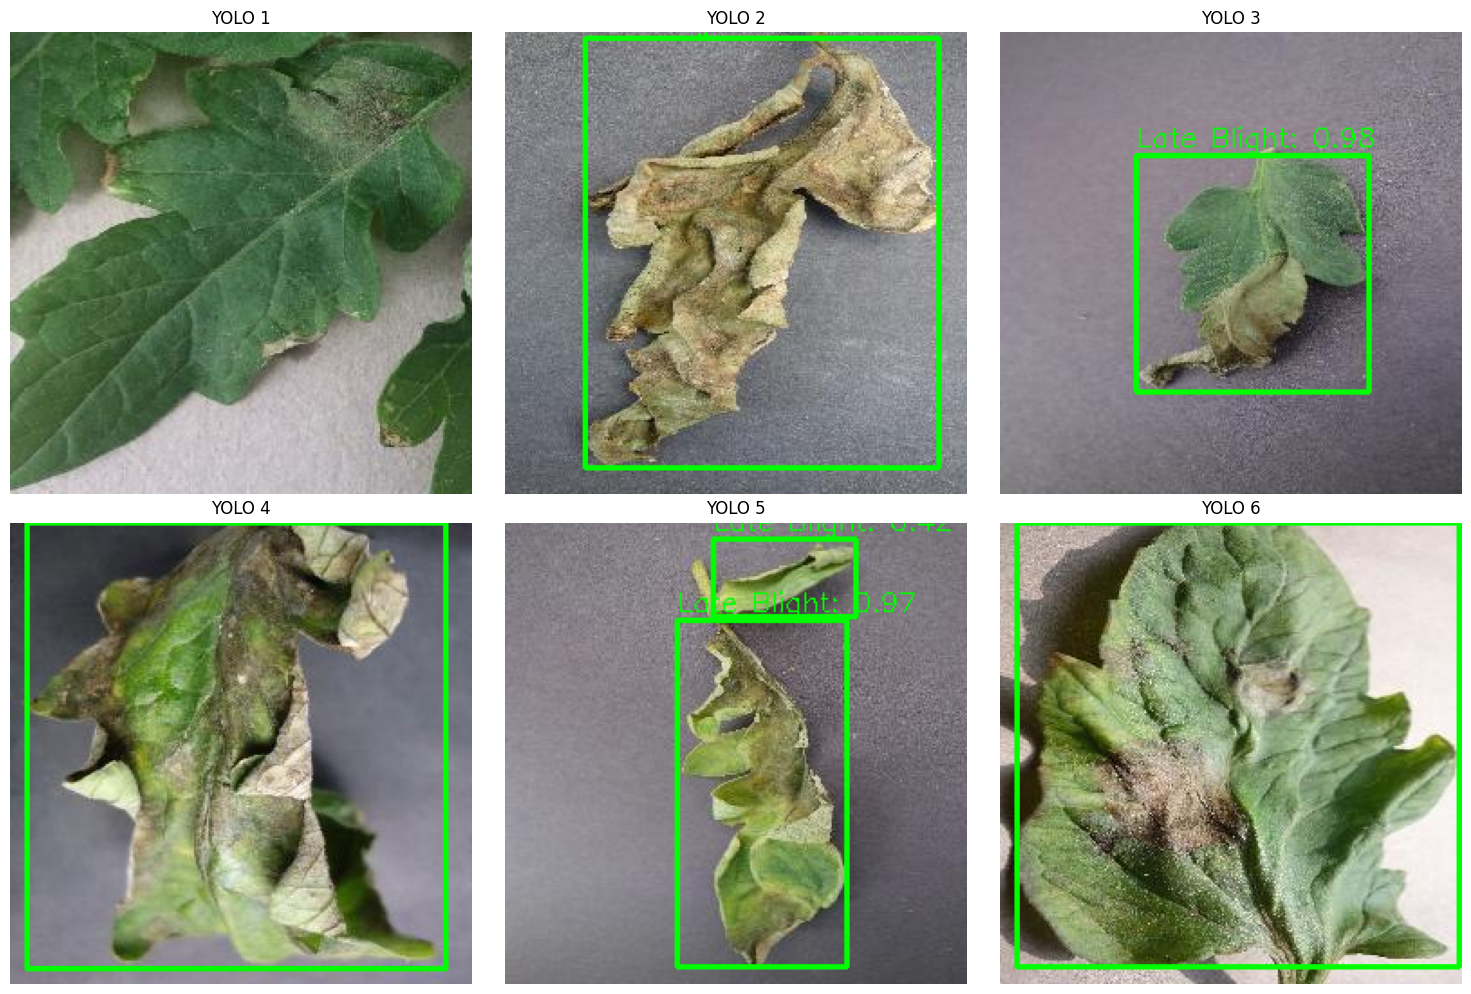

In [29]:
import os
import cv2
import matplotlib.pyplot as plt

# Select a few test images (first 6 from test set)
test_img_dir = os.path.join(dataset_dir, 'valid', 'images')
test_images = sorted(os.listdir(test_img_dir))[:6]

images = []
results_list = []
for img_name in test_images:
    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    images.append(img)
    results_list.append(model(img_path, verbose=False)[0])

plot_yolo_grid(images, results_list, class_names)

## 10. Segment the Same Images with SAM2 (using YOLO boxes)

Image 1: No boxes detected.
Image 2: 1 boxes detected.
  -> Generated 1 masks.
     Mask area: 19938 pixels
Image 3: 1 boxes detected.
  -> Generated 1 masks.
     Mask area: 8882 pixels
Image 4: 1 boxes detected.
  -> Generated 1 masks.
     Mask area: 32693 pixels
Image 5: 2 boxes detected.
  -> Generated 2 masks.
     Mask area: 9474 pixels
     Mask area: 1428 pixels
Image 6: 1 boxes detected.
  -> Generated 1 masks.
     Mask area: 43830 pixels


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


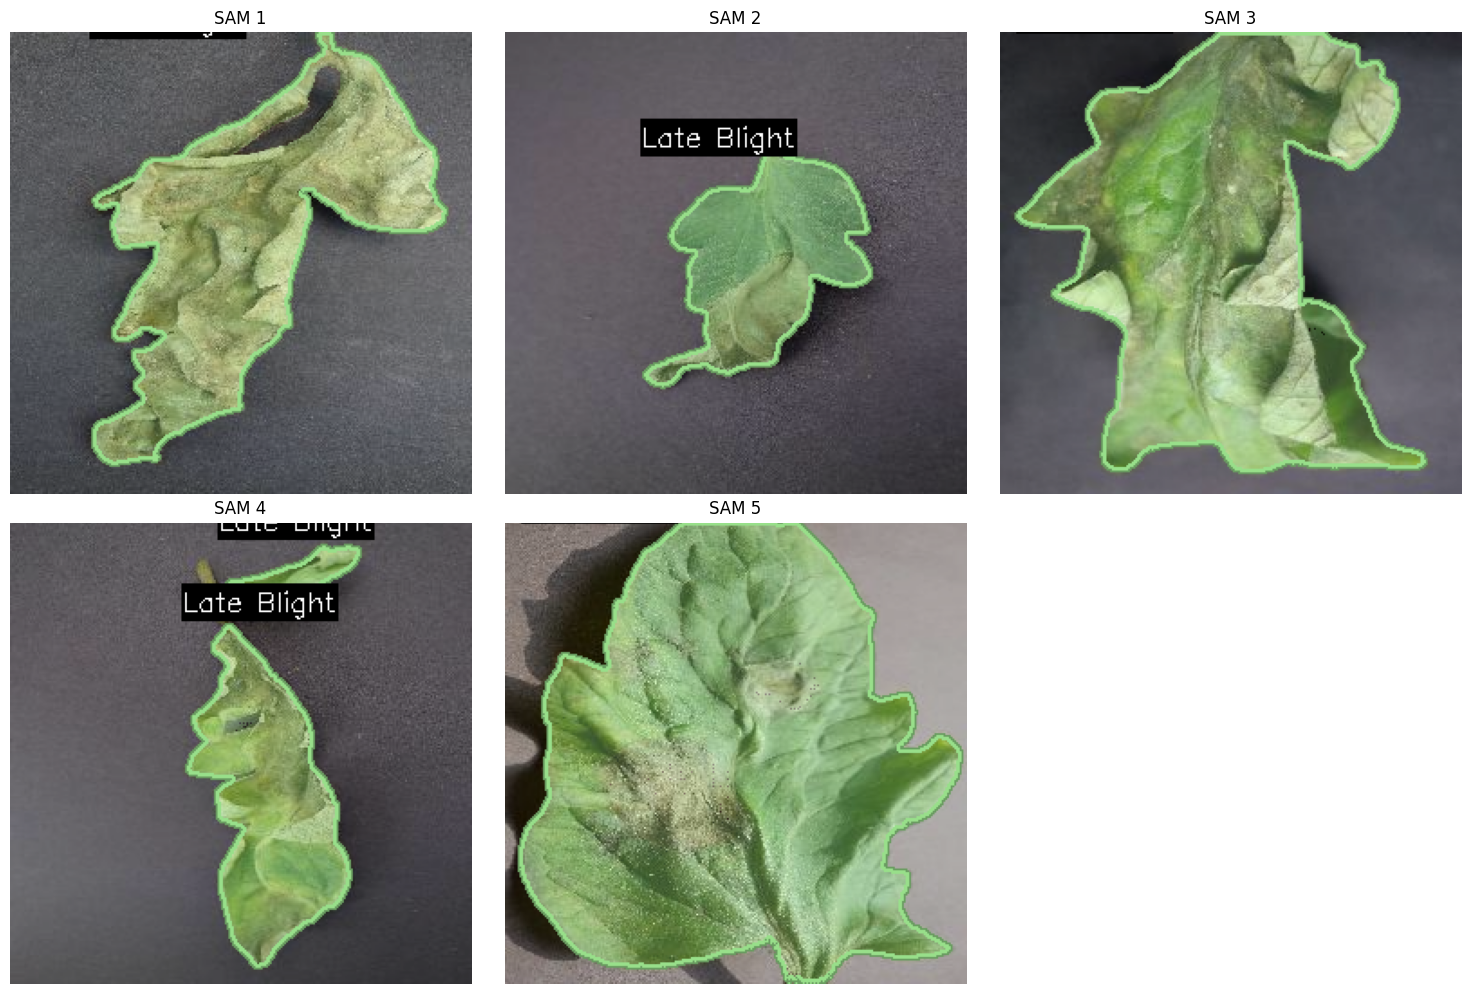

In [34]:
sam_results_list = []
for idx, (img_path, yolo_result) in enumerate(zip([os.path.join(test_img_dir, f) for f in test_images], results_list)):
    boxes = yolo_result.boxes.xyxy.cpu().numpy() if yolo_result.boxes is not None else None
    if boxes is not None and len(boxes) > 0:
        print(f"Image {idx+1}: {len(boxes)} boxes detected.")
        sam_result = sam_model(img_path, bboxes=boxes, verbose=False, device=0)[0]
        # Transfer class info
        sam_result.boxes = yolo_result.boxes
        sam_result.names = yolo_result.names
        if sam_result.masks is not None:
            print(f"  -> Generated {len(sam_result.masks)} masks.")
            # Check if masks are reasonably sized (not covering whole image)
            for m in sam_result.masks.data:
                area = (m > 0).sum().item()
                print(f"     Mask area: {area} pixels")
        else:
            print("  -> No masks generated.")
    else:
        sam_result = None
        print(f"Image {idx+1}: No boxes detected.")
    sam_results_list.append(sam_result)

# Filter only images with both boxes and masks
valid_indices = [i for i, r in enumerate(sam_results_list) if r is not None and r.masks is not None and len(r.masks) > 0]
valid_images = [images[i] for i in valid_indices]
valid_sam_results = [sam_results_list[i] for i in valid_indices]

if valid_sam_results:
    plot_sam_grid(valid_images, valid_sam_results, class_names)
else:
    print("No valid segmentation results to display.")

## 11. Save Example Outputs to Drive

In [31]:
output_dir = os.path.join(drive_model_dir, 'example_outputs')
os.makedirs(output_dir, exist_ok=True)

# Save YOLO and SAM results for the first few images
for i, (img_name, yolo_res) in enumerate(zip(test_images[:3], results_list[:3])):
    yolo_res.save(filename=os.path.join(output_dir, f"yolo_{img_name}"))
    if i < len(valid_sam_results):
        sam_res = valid_sam_results[i]
        if not hasattr(sam_res, 'names') or sam_res.names is None:
            sam_res.names = yolo_res.names
        sam_res.save(filename=os.path.join(output_dir, f"sam_{img_name}"))
        print(f"Saved SAM result for {img_name}")

print(f"Example outputs saved to {output_dir}")

Saved SAM result for Late-Blight-1-_jpeg.rf.aeac1f4af808eb9487ff2aa3e4d4c715.jpg
Saved SAM result for Late-Blight-1003-_JPG.rf.17c38cbba350eede3f47cbc390c628e9.jpg
Saved SAM result for Late-Blight-1004-_JPG.rf.6a656b5a5700fb8b81aac14bb14fe823.jpg
Example outputs saved to /content/drive/MyDrive/tomato_leaf_model/example_outputs


## 12. Evaluation on Test Set

In [27]:
# Check if test folder exists, otherwise use validation
test_path = os.path.join(dataset_dir, 'test', 'images')
if os.path.exists(test_path):
    split = 'test'
    print("Evaluating on test set...")
else:
    split = 'val'
    print("Test folder not found. Evaluating on validation set instead.")

metrics = model.val(data=data_yaml_path, split=split)
print("Evaluation complete. Metrics:")
print(metrics)

Test folder not found. Evaluating on validation set instead.
Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 962.3±453.9 MB/s, size: 17.5 KB)
val: Scanning /content/Tomato-Leaf-Disease-7/valid/labels.cache... 3927 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3927/3927 203.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 246/246 7.8it/s 31.5s
                   all       3927       4099      0.698      0.795      0.802      0.756
               Healthy          8          9      0.533      0.888      0.861      0.793
           Late Blight        530        543      0.724       0.91       0.93      0.861
             Leaf Mold        600        609      0.956      0.925      0.977      0.926
          Mosaic Virus        610        624       0.93      0.934      0.974      0.908
              Septoria        707        714    

## ✅ Summary
All models and results are stored in your Google Drive (`/content/drive/MyDrive/tomato_leaf_model/`). The notebook now:
- Persists data and models across sessions
- Displays professional training graphs
- Shows YOLO detections and SAM segmentations on multiple test images
- Preserves class labels from YOLO in the segmentation output